In [1]:
from datasets import load_dataset
import os
import sys
import argparse
import deepspeed
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    default_data_collator,
    get_linear_schedule_with_warmup,
    set_seed,
    pipeline
)
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

/data/lypan/anaconda3/envs/chatglm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-02-16 00:18:17,606] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2024-02-16 00:18:23.766419: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-16 00:18:23.855884: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 00:18:23.855964: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 00:18:23.856008: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 00:18:23.873677: I tensorflow/core/platform/cpu_feature_g

In [2]:
output_dir = '/data/lypan/llms/bloom-7b1'
# tokenizer,model = llm_util.get_model('/home/sxy/Projects/Models/bloomz-7b1-mt')
tokenizer = AutoTokenizer.from_pretrained(output_dir, use_fast=False, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(output_dir, device_map="cuda:4", trust_remote_code=True)

Loading checkpoint shards: 100%|██████████| 2/2 [00:31<00:00, 15.96s/it]


In [3]:
layer_name_list = ["transformer.h." + str(i) for i in range(model.config.num_hidden_layers)]
def read_text(path):
    new_list = []
    with open(path,'r') as r:
        for i in r.readlines()[:500]:
            new_list.append(i.replace('\n',''))
    return new_list

ar = "/data/lypan/peft/data/flores200_dataset/dev/arb_Arab.dev"
en = "/data/lypan/peft/data/flores200_dataset/dev/eng_Latn.dev"
fr = "/data/lypan/peft/data/flores200_dataset/dev/fra_Latn.dev"
es = "/data/lypan/peft/data/flores200_dataset/dev/spa_Latn.dev"
zh = "/data/lypan/peft/data/flores200_dataset/dev/zho_Hans.dev"
de = "/data/lypan/peft/data/flores200_dataset/dev/deu_Latn.dev"
it = "/data/lypan/peft/data/flores200_dataset/dev/ita_Latn.dev"
ar_list = read_text(ar)
en_list = read_text(en)
fr_list = read_text(fr)
es_list = read_text(es)
zh_list = read_text(zh)
de_list = read_text(de)
it_list = read_text(it)


def get_prompt(language,e_q,q):
    if language == 'test':
        return "Translate the following sentence from English to French:\nEnglish:"+e_q+"\nFrench:"+q
    if language == 'Romanian':
        return "Translate the following sentence from English to Romanian:\nEnglish:"+e_q+"\nRomanian:"+q
    if language == 'Polish':
        return "Translate the following sentence from English to Polish:\nEnglish:"+e_q+"\nPolish:"+q
    if language == 'Hebrew':
        return "Translate the following sentence from English to Hebrew:\nEnglish:"+e_q+"\nHebrew:"+q
    if language == 'German':
        return "Translate the following sentence from English to German:\nEnglish:"+e_q+"\nGerman:"+q
    if language == 'German_r':
        return "Translate the following sentence from German to English:\nGerman:"+q+"\nEnglish:"+e_q
    if language == 'Arabic':
        return "Translate the following sentence from English to Arabic:\nEnglish:"+e_q+"\nArabic:"+q
    if language == 'Arabic_r':
        return "Translate the following sentence from Arabic to English:\nArabic:"+q+"\nEnglish:"+e_q
    if language == 'Spanish':
        return "Translate the following sentence from English to Spanish:\nEnglish:"+e_q+"Spanish:"+q
    if language == 'Spanish_r':
        return "Translate the following sentence from Spanish to English:\nSpanish:"+q+"English:"+e_q
    if language == 'Chinese':
        return "Translate the following sentence from English to Chinese:\nEnglish:"+e_q+"Chinese:"+q
    if language == 'Chinese_r':
        return "Translate the following sentence from Chinese to English:\nChinese:"+q+"English:"+e_q
    if language == 'Persian':
        return "Translate the following sentence from English to Persian:\nEnglish:"+e_q+"Persian:"+q
    if language == 'Italian':
        return "Translate the following sentence from English to Italian:\nEnglish:"+e_q+"Italian:"+q
    if language == 'Italian_r':
        return "Translate the following sentence from Italian to English:\nItalian:"+q+"\nEnglish:"+e_q
    if language == 'Dutch':
        return "Translate the following sentence from English to Dutch:\nEnglish:"+e_q+"Dutch:"+q
    if language == 'Portuguese':
        return "Translate the following sentence from English to Portuguese:\nEnglish:"+e_q+"Portuguese:"+q
    if language == 'Portuguese_r':
        return "Translate the following sentence from Portuguese to English:\nPortuguese:"+q+"English:"+e_q
    if language == 'Russian':
        return "Translate the following sentence from English to Russian:\nEnglish:"+e_q+"Russian:"+q
    if language == 'Slovenian':
        return "Translate the following sentence from English to Slovenian:\nEnglish:"+e_q+"Slovenian:"+q
    if language == 'Turkish':
        return "Translate the following sentence from English to Turkish:\nEnglish:"+e_q+"Turkish:"+q
    if language == 'French':
        return "Translate the following sentence from English to French:\nEnglish:"+e_q+"French:"+q
    if language == 'French_r':
        return "Translate the following sentence from French to English:\nFrench:"+q+"English:"+e_q
    if language == "in-context":
        return "Translate the following sentence from English to French:\nEnglish:from a long-term drive  to increase future freedom of action.\nFrench:d'une tendance sur le long terme à augmenter la liberté d'action future.\nEnglish:"+q+"\nFrench:"

    return "this is error"

language_list = ["Arabic", "German", "Italian", "French", "Chinese", "Arabic_r", "German_r", "Italian_r", "French_r", "Chinese_r"]
text_list = [ar_list, de_list, it_list, fr_list, zh_list, ar_list, de_list, it_list, fr_list, zh_list]
all_lang_avg_layer_activations = []

for lang in language_list:
    lang_index = language_list.index(lang)
    en_texts = en_list
    texts = text_list[lang_index]
    model.eval()
    all_layer_activations = [[] for _ in range(model.config.num_hidden_layers)]

    # 自定义forward hook函数
    def get_activation(layer_idx):
        def hook(model, input, output):
            all_layer_activations[layer_idx].append(output[0].mean().item())
        return hook

    # 注册hook
    hooks = []
    # for i, layer in enumerate(model.model.layers):
    #     hook = layer.register_forward_hook(get_activation(i))
    #     hooks.append(hook)
    for name, module in model.named_modules():
        if name in layer_name_list:
            hook = module.register_forward_hook(get_activation(layer_name_list.index(name)))
            hooks.append(hook)
    # 对每个文本进行前向传播
    zipped_text = list(zip(en_texts, texts))

    for i in tqdm(range(len(zipped_text)), desc=lang):
        en_text, text = zipped_text[i]
        q = get_prompt(lang, en_text, text)
        inputs = tokenizer(q, return_tensors="pt").to('cuda:4')
        with torch.no_grad():
            outputs = model(input_ids = inputs['input_ids'], attention_mask = inputs['attention_mask'])

    # 移除hooks
    for hook in hooks:
        hook.remove()

    # 计算每层的平均激活值
    avg_layer_activations = [sum(layer_activations) / len(layer_activations) for layer_activations in all_layer_activations]
    all_lang_avg_layer_activations.append(avg_layer_activations)
    # 计算每层的平均激活值的变化
    # delta_avg_layer_activations = [(avg_layer_activations[i+1] - avg_layer_activations[i]) for i in range(len(avg_layer_activations)-1)]

Arabic:   0%|          | 0/500 [00:00<?, ?it/s]

Chinese_r: 100%|██████████| 500/500 [00:49<00:00, 10.19it/s]


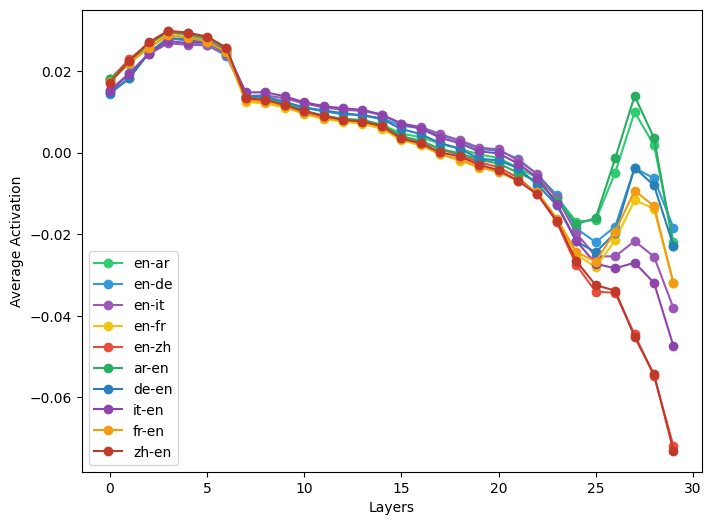

In [12]:
color_list = ["#2ecc71", "#3498db", "#9b59b6", "#f1c40f", "#e74c3c", "#27ae60", "#2980b9", "#8e44ad", "#f39c12", "#c0392b"]
# 创建图表
plt.figure(figsize=(8, 6))

plt.plot(all_lang_avg_layer_activations[0], label='en-ar', marker='o', color=color_list[0])
plt.plot(all_lang_avg_layer_activations[1], label='en-de', marker='o', color=color_list[1])
plt.plot(all_lang_avg_layer_activations[2], label='en-it', marker='o', color=color_list[2])
plt.plot(all_lang_avg_layer_activations[3], label='en-fr', marker='o', color=color_list[3])
plt.plot(all_lang_avg_layer_activations[4], label='en-zh', marker='o', color=color_list[4])
plt.plot(all_lang_avg_layer_activations[5], label='ar-en', marker='o', color=color_list[5])
plt.plot(all_lang_avg_layer_activations[6], label='de-en', marker='o', color=color_list[6])
plt.plot(all_lang_avg_layer_activations[7], label='it-en', marker='o', color=color_list[7])
plt.plot(all_lang_avg_layer_activations[8], label='fr-en', marker='o', color=color_list[8])
plt.plot(all_lang_avg_layer_activations[9], label='zh-en', marker='o', color=color_list[9])

plt.xlabel('Layers')
plt.ylabel('Average Activation')

# 添加图例
plt.legend()

plt.savefig("fig/average_activation.pdf", dpi=300)
# 显示图表
plt.show()

In [10]:
all_lang_delta_avg_layer_activations =[]
for i in range(len(all_lang_avg_layer_activations)):
    avg_layer_activations = all_lang_avg_layer_activations[i]
    delta_avg_layer_activations = [abs(avg_layer_activations[i+1] - avg_layer_activations[i]) for i in range(len(avg_layer_activations)-1)]
    all_lang_delta_avg_layer_activations.append(delta_avg_layer_activations)

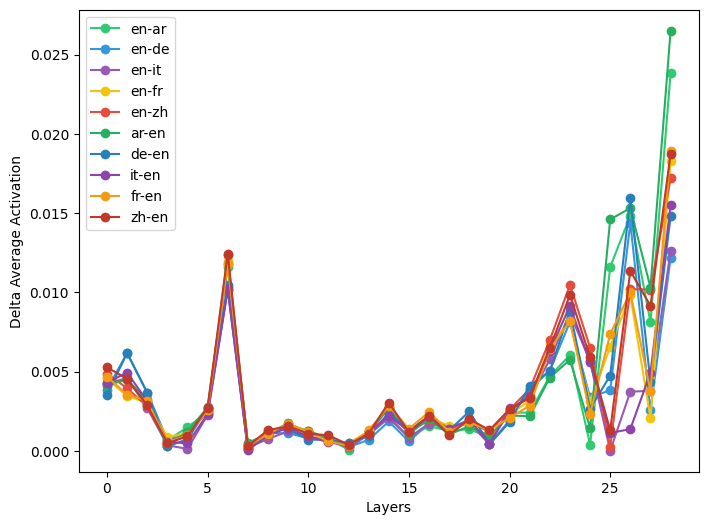

In [13]:
color_list = ["#2ecc71", "#3498db", "#9b59b6", "#f1c40f", "#e74c3c", "#27ae60", "#2980b9", "#8e44ad", "#f39c12", "#c0392b"]
# 创建图表
plt.figure(figsize=(8, 6))

plt.plot(all_lang_delta_avg_layer_activations[0], label='en-ar', marker='o', color=color_list[0])
plt.plot(all_lang_delta_avg_layer_activations[1], label='en-de', marker='o', color=color_list[1])
plt.plot(all_lang_delta_avg_layer_activations[2], label='en-it', marker='o', color=color_list[2])
plt.plot(all_lang_delta_avg_layer_activations[3], label='en-fr', marker='o', color=color_list[3])
plt.plot(all_lang_delta_avg_layer_activations[4], label='en-zh', marker='o', color=color_list[4])
plt.plot(all_lang_delta_avg_layer_activations[5], label='ar-en', marker='o', color=color_list[5])
plt.plot(all_lang_delta_avg_layer_activations[6], label='de-en', marker='o', color=color_list[6])
plt.plot(all_lang_delta_avg_layer_activations[7], label='it-en', marker='o', color=color_list[7])
plt.plot(all_lang_delta_avg_layer_activations[8], label='fr-en', marker='o', color=color_list[8])
plt.plot(all_lang_delta_avg_layer_activations[9], label='zh-en', marker='o', color=color_list[9])

plt.xlabel('Layers')
plt.ylabel('Delta Average Activation')

# 添加图例
plt.legend()

plt.savefig("fig/delta_average_activation.pdf", dpi=300)
# 显示图表
plt.show()